# Version 8: Optimized Model with Best Hyperparameters

## Introduction: Changes & Purpose
In Version 8, we performed further optimization by fine-tuning the model hyperparameters based on insights from previous experiments.
- **Change:** The best-performing hyperparameters were selected and applied to the model.
- **Purpose:** The goal was to achieve a better balance between bias and variance, ensuring optimal performance and generalization on unseen data.


🔹 Relevant features after Lasso: ['Model', 'Engine_Size', 'Fuel_Type', 'Transmission', 'Car_Age', 'Mileage_sqrt']
🔍 Testing Ridge...
✅ Ridge - RMSE: 565.23, R²: 0.9657
🔍 Testing Lasso...
✅ Lasso - RMSE: 527.82, R²: 0.9701
🔍 Testing ElasticNet...
✅ ElasticNet - RMSE: 552.25, R²: 0.9673

🚀 Best model: Lasso with RMSE: 527.82


2025/03/15 23:39:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLflow run completed!


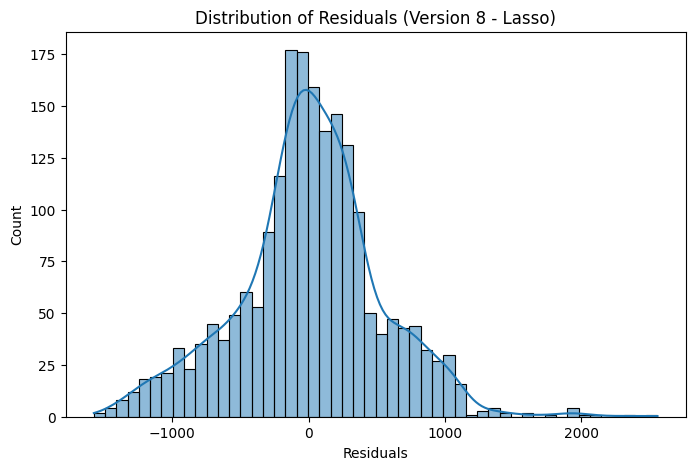

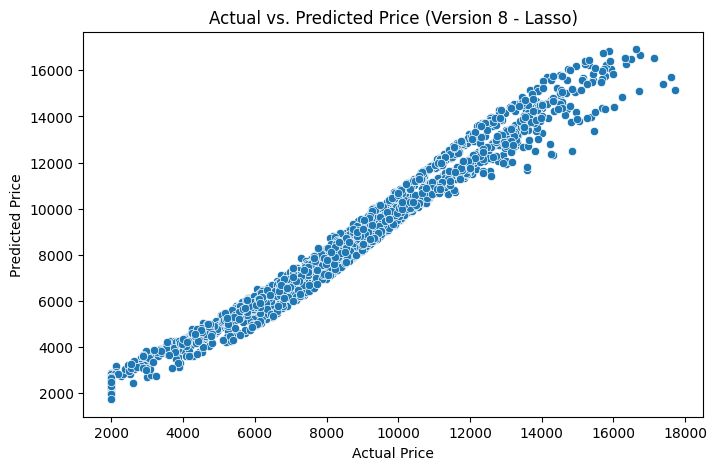

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow
import mlflow.sklearn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Initialize MLflow experiment
mlflow.set_experiment("Car Price Prediction - Version 8")

with mlflow.start_run():
    # Load data
    df = pd.read_csv("car_price_dataset.csv")

    # Remove unrealistic values
    df = df[(df["Price"] >= 2000) & (df["Price"] <= 18000)]
    df = df[(df["Mileage"] >= 0) & (df["Mileage"] <= 300000)]
    df = df[(df["Engine_Size"] >= 0.8) & (df["Engine_Size"] <= 6.0)]
    df["Car_Age"] = 2025 - df["Year"]

    # Label encoding for categorical data
    categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
    label_encoders = {}

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Feature engineering: transform mileage
    df["Mileage_sqrt"] = np.sqrt(df["Mileage"])

    # Remove unnecessary columns
    df.drop(columns=["Year", "Mileage"], inplace=True)

    # Standardize numerical features
    scaler = StandardScaler()
    numeric_features = ["Engine_Size", "Mileage_sqrt", "Car_Age", "Doors"]
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # Transform target variable
    df["Log_Price"] = np.log1p(df["Price"])

    # Create training and test data
    X = df.drop(columns=["Price", "Log_Price"])
    y = df["Log_Price"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature selection with Lasso
    lasso = Lasso(alpha=0.01)
    lasso.fit(X_train, y_train)
    feature_importance = np.abs(lasso.coef_)

    # Select relevant features
    selected_features = X.columns[feature_importance > 0]
    print(f"🔹 Relevant features after Lasso: {list(selected_features)}")

    X_train = X_train[selected_features]
    X_test = X_test[selected_features]

    # Models with different regularization types
    models = {
        "Ridge": (Ridge(), {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10]}),
        "Lasso": (Lasso(), {"lasso__alpha": [0.001, 0.01, 0.1, 1, 10]}),
        "ElasticNet": (ElasticNet(), {"elasticnet__alpha": [0.001, 0.01, 0.1, 1, 10], "elasticnet__l1_ratio": [0.1, 0.5, 0.9]})
    }

    best_model = None
    best_rmse = float("inf")
    best_model_name = ""

    for model_name, (model, param_grid) in models.items():
        print(f" Testing {model_name}...")

        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Test only degree 1 & 2
            ('scaler', StandardScaler()),
            (model_name.lower(), model)
        ])

        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_mean_squared_error")
        grid_search.fit(X_train, y_train)

        # Save best model if it has the best RMSE
        y_pred_log = grid_search.best_estimator_.predict(X_test)
        y_pred = np.expm1(y_pred_log)
        rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
        r2 = r2_score(np.expm1(y_test), y_pred)

        print(f"✅ {model_name} - RMSE: {rmse:.2f}, R²: {r2:.4f}")

        mlflow.log_param(f"{model_name}_params", grid_search.best_params_)
        mlflow.log_metric(f"{model_name}_RMSE", rmse)
        mlflow.log_metric(f"{model_name}_R2", r2)

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = grid_search.best_estimator_
            best_model_name = model_name

    print(f"\n Best model: {best_model_name} with RMSE: {best_rmse:.2f}")

    # Log best model
    model_filename = f"{best_model_name}_model_v8.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(best_model, f)

    mlflow.sklearn.log_model(best_model, f"{best_model_name}_model_v8")

    print("✅ MLflow run completed!")

    # Residual analysis
    y_pred_log = best_model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    plt.figure(figsize=(8, 5))
    sns.histplot(np.expm1(y_test) - y_pred, bins=50, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Count")
    plt.title(f"Distribution of Residuals (Version 8 - {best_model_name})")
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=np.expm1(y_test), y=y_pred)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs. Predicted Price (Version 8 - {best_model_name})")
    plt.show()


## Results Discussion
The optimized model in Version 8 achieved an RMSE of *527.82* and an R² of *0.9701*.  
These metrics indicate that the fine-tuning has successfully balanced the complexity and predictive accuracy of the model. The results are robust and suggest that the model is well-suited for further deployment.
